# **Inversión 2D con Datos de Cerro Machín**
**Elaborador por:** \
Johan Enrique Páez Romero 2210631 \
Ivan Camilo Caballero Jaimes 2210625 \
Semillero de Investigación en Geofísica Aplicada y Computacional - **SIGAC**

## Librerías

In [1]:
import numpy as np
from copy import deepcopy
from pathlib import Path
import pandas as pd
from mtpy import MT, MTCollection
import inspect
from mtpy.core.z import Z
## mtpy 1.1.5
## mtpy-v2 2.0.7
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np
import unittest
from scipy.constants import mu_0
from discretize.tests import check_derivative
import discretize
import matplotlib.patheffects as pe
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG.electromagnetics.static import utils as sutils
from SimPEG import (
    maps, utils, optimization, objective_function, inversion, inverse_problem, directives,
    data_misfit, regularization, data
)
from discretize import TensorMesh
## ERROR-----> 
from pymatsolver import Solver
# Antes -> "import Pardiso"
# Corregir -> "import Solver"

from scipy.spatial import cKDTree
from scipy.stats import norm
# from dask.distributed import Client, LocalCluster
import dill
from geoana.em.fdem import skin_depth
import discretize.utils as dis_utils
import warnings
warnings.filterwarnings("ignore")

from SimPEG.utils import mkvc, model_builder
from discretize.utils import active_from_xyz

import h5py
import sys


## Abrir archivo .h5

In [2]:
# Abrir los datos del perfil, creados en el notebbok acondicionamiento.ipynb
mt_df = pd.read_hdf("../../data/transfers_functions/level_0/cerromachin_perfil02.h5", key="mt_data")

In [3]:
mt_df.head(10)

,survey,station,latitude,longitude,elevation,datum_epsg,east,north,utm_epsg,model_east,...,ptyx_model_error,ptyy,ptyy_error,ptyy_model_error,rms_zxx,rms_zxy,rms_zyx,rms_zyy,rms_tzx,rms_tzy
0,MC,MC0036,4.502417,-75.391194,2318.0,4326,456602.955274,497674.225585,32618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MC,MC0036,4.502417,-75.391194,2318.0,4326,456602.955274,497674.225585,32618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MC,MC0036,4.502417,-75.391194,2318.0,4326,456602.955274,497674.225585,32618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MC,MC0036,4.502417,-75.391194,2318.0,4326,456602.955274,497674.225585,32618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MC,MC0036,4.502417,-75.391194,2318.0,4326,456602.955274,497674.225585,32618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,MC,MC0036,4.502417,-75.391194,2318.0,4326,456602.955274,497674.225585,32618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,MC,MC0036,4.502417,-75.391194,2318.0,4326,456602.955274,497674.225585,32618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,MC,MC0036,4.502417,-75.391194,2318.0,4326,456602.955274,497674.225585,32618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,MC,MC0036,4.502417,-75.391194,2318.0,4326,456602.955274,497674.225585,32618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,MC,MC0036,4.502417,-75.391194,2318.0,4326,456602.955274,497674.225585,32618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Generamos una lista con las estaciones, su distancia en el perfil y elevación, para la topografía
name_station = mt_df["station"].unique()
offset = mt_df["profile_offset"].unique()
elevation = mt_df["elevation"].unique()
stations = [name_station, offset, elevation]

In [5]:
# Obtiene el numero de estaciones
n_stations = mt_df.station.unique().size

# Genera un array de localizacion de las estaciones (x,y),
#rx_locs = np.c_[mt_df.profile_offset.unique(), np.zeros(n_stations)]
rx_locs = np.c_[mt_df.profile_offset.unique(), elevation]


# Extrae los datos de frecuencias
frequencies = 1./mt_df.period.unique()

# Crear arrays vacíos para las resistividades aparentes y fases
app_rho_te = np.zeros((frequencies.size, rx_locs.shape[0]))
app_rho_tm = np.zeros((frequencies.size, rx_locs.shape[0]))
phase_te = np.zeros((frequencies.size, rx_locs.shape[0]))
phase_tm = np.zeros((frequencies.size, rx_locs.shape[0]))

# Itera sobre cada estación y llena los arrays con los valores de resistivdad aparente y fase para ambos modos (TE y TM)
for index, station in enumerate(mt_df.station.unique()):
    sdf = mt_df[mt_df.station == station]
    sdf.sort_values("period")
    app_rho_te[:, index] = sdf.res_xy
    app_rho_tm[:, index] = sdf.res_yx
    phase_te[:, index] = sdf.phase_xy
    phase_tm[:, index] = sdf.phase_yx
    

In [6]:
print(rx_locs)

[[   0.         2318.        ]
 [1471.94598521 2514.        ]
 [1879.30191605 2506.        ]
 [2392.64531227 2523.        ]
 [3889.21588275 2408.        ]
 [4906.46733987 2526.        ]
 [5871.30521731 2185.        ]
 [7551.08792975 1787.        ]]


## Perfil

In [7]:
# Crear un perfil con los datos de las estaciones
import numpy as np
from scipy.interpolate import interp1d
def create_perfil(topoxz):
    x = topoxz[0]
    z = topoxz[1]

    interp_func = interp1d(x,z, kind="linear", fill_value="extrapolate")
    return interp_func

# Crea una función donde se ingresa una distancia del perfil y le indica la altura
def get_altura(interp_func, x_point):
    altura = interp_func(x_point)
    return altura

In [8]:
perfil1 = create_perfil(stations[1:3])

In [9]:
altura2 = []

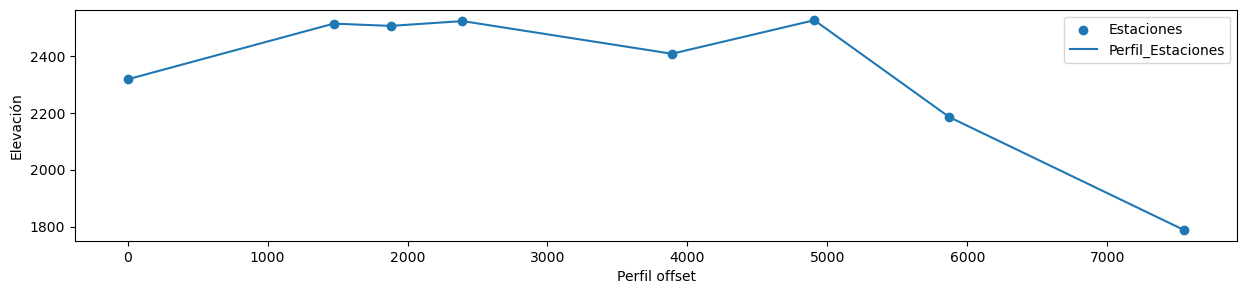

In [10]:
fig = plt.figure(figsize=(15, 3))
plt.scatter(stations[1], stations[2], label="Estaciones")
plt.plot(stations[1], stations[2], label="Perfil_Estaciones")
plt.xlabel("Perfil offset")
plt.ylabel("Elevación")
plt.legend()

## Mesh
Se crea la función que crea la malla discretizada

A continuación, se asignará los valores de los hiperparametros para la inversión y además se genera la malla

In [11]:
# ---> Valores para la inverrsión
nskip_freq = 7
nskip_rx = 3
relative_error =  0.30
floor_error = 1.5
# Hiperparametros de la norma modelo
alpha_s = 1e-5
alpha_y = 1/5.
alpha_z = 1.

rho_0 = 50.
maxIter = 30
use_irls = True

# Hiperparametros de la norma Lp
p_s=2.
p_y=1.
p_z=1.

# obetener los datos de error de resistividad app y fase
app_rho_err_tm = abs(app_rho_tm) * relative_error
app_rho_err_te = abs (app_rho_te) * relative_error
phase_err_tm = np.ones_like(phase_tm) * floor_error
phase_err_te = np.ones_like(phase_te) * floor_error

In [12]:
#rx_locs, 
#frequencies, 
sigma_background = 5 ### Conducitivdad de fondo
spacing_factor=5
x_factor_max=5
pfz_up = 1.1
npadz_up = 40
pfx = 1.2
# Parametros que controlan el ajuste vertical
z_factor_min = 2
z_factor_max = 3 #Ajusta el grosor de las primeras celdas en función del skin depth
pfz_down = 1.1 #Si se aumenta, las celdas crecen más rápido
n_max = 100 # número máximo de celdas 
# get minimum cell size (first layer thickness)
dz_min = np.round(skin_depth(frequencies.max(), sigma_background) / z_factor_max) 
lz = skin_depth(sigma_background, frequencies.min()) * z_factor_max

# Setting the domain length in subsurface
for nz_down in range(n_max):
    hz_down = dz_min*pfz_down**np.arange(nz_down)[::-1]
    if hz_down.sum() > lz:
        break
# create air layers
hz_up = [(dz_min, npadz_up, pfz_up)]
hz_up = dis_utils.unpack_widths(hz_up)

# combine air and subsurface
hz = np.r_[hz_down, hz_up]

# Setting the cells in lateral dimension
# station spacing
d_station = np.diff(rx_locs[:,0]).min()
# minimum cell width
dx_min = np.round(d_station/spacing_factor)
print(dx_min)
# survey span
lx = rx_locs[:,0].max() - rx_locs[:,0].min()
ncx = int(lx / dx_min)

# make padding cells
lx_pad = skin_depth(sigma_background, frequencies.min()) * x_factor_max
for npadx in range(n_max):
    hx_pad = dis_utils.unpack_widths([(dx_min, npadx, -pfx)])
    if hx_pad.sum()>lx_pad:
        break
# combine paddin cells with station area cells
hx = [(dx_min, npadx, -pfx), (dx_min, ncx+spacing_factor), (dx_min, npadx, pfx)]  

"""
# make a discretize.TensorMesh object
mesh = discretize.TensorMesh([hx, hz])

# get the lower left corner of the mesh, the origin
mesh.origin = np.r_[-mesh.h[0][:npadx].sum()+rx_locs[:,0].min() - spacing_factor * dx_min/2, -hz_down.sum()] 
mesh.x0 = mesh.x0 + np.array([0, -mesh.nodes_y[int(np.searchsorted(mesh.nodes_y, 0))]])


print (mesh)

ax = mesh.plot_grid()
ax.set_xlim(-500, 9500)
ax.set_ylim(-3500, 4000)
ax.plot(rx_locs[:, 0], rx_locs[:, 1], "rv")
"""

81.0


'\n# make a discretize.TensorMesh object\nmesh = discretize.TensorMesh([hx, hz])\n\n# get the lower left corner of the mesh, the origin\nmesh.origin = np.r_[-mesh.h[0][:npadx].sum()+rx_locs[:,0].min() - spacing_factor * dx_min/2, -hz_down.sum()] \nmesh.x0 = mesh.x0 + np.array([0, -mesh.nodes_y[int(np.searchsorted(mesh.nodes_y, 0))]])\n\n\nprint (mesh)\n\nax = mesh.plot_grid()\nax.set_xlim(-500, 9500)\nax.set_ylim(-3500, 4000)\nax.plot(rx_locs[:, 0], rx_locs[:, 1], "rv")\n'

In [13]:
long_X = rx_locs[:,0].max()
print(long_X)
long_Z = rx_locs[:,1].max()+3000
print(rx_locs[:,1].max(), long_Z)

7551.087929753354
2526.0 5526.0


In [14]:
dh=180
#(dh, no. de celdas, factor de crecimiento opcional)
#hx3 = [(dx_min, npadx, -pfx), (dx_min, ncx+spacing_factor), (dx_min, npadx, pfx)]  
#hx3 = [(161, 11, -1.2), (161, 60), (161, 11, 1.2)]
hx3 = [(long_X/50, 5, -1),(long_X/50,50), (long_X/50, 5, 1)]
#hz3 = np.r_[hz_down, hz_up]
#hz3 = [(dh, 6, -1.1), (dh, 20), (dh, 6, 1.1)]
hz3 = [(long_Z/50,50), (long_Z/50, 2, 1)]
origin = [-long_X/10, -3000]
mesh3 = TensorMesh([hx3, hz3], origin)
"""
print(npadx)
print(pfx)
print(dx_min)
print(ncx+spacing_factor)

print(hz_down)
"""
print(hz3)


[(110.52, 50), (110.52, 2, 1)]


In [15]:
#mesh3.origin = np.r_[-mesh3.h[0][:npadx].sum()+rx_locs[:,0].min() - spacing_factor * dx_min/2, -hz_down.sum()] 
#mesh3.x0 = mesh3.x0 + np.array([0, -mesh3.nodes_y[int(np.searchsorted(mesh3.nodes_y, 0))]])

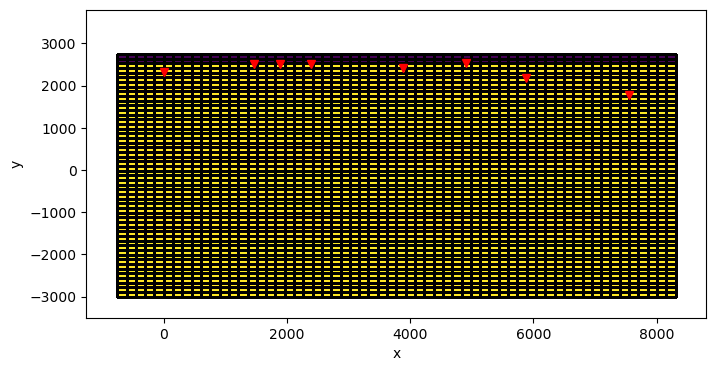

In [16]:
halfspace_value = 10.0

# Find cells below topography and define mapping
air_value = 0.0
ind_active = mesh3.gridCC[:, 1] < 2500.0
model_map = maps.InjectActiveCells(mesh3, ind_active, air_value)

# Define the model
model = halfspace_value * np.ones(ind_active.sum())

# We can plot a slice of the model at Y=-2.5
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
mesh3.plot_image(model_map * model, ax=ax, grid=True)
ax.plot(rx_locs[:, 0], rx_locs[:, 1], "rv")
ax.set_xlim(-0.1*long_X-500, 1.1*long_X+500)
ax.set_ylim(-3500, 3800)

plt.show()

In [17]:
print(mesh3)


  TensorMesh: 3,120 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     60       -755.11      8,306.20    151.02    151.02    1.00
   y     52     -3,000.00      2,747.04    110.52    110.52    1.00




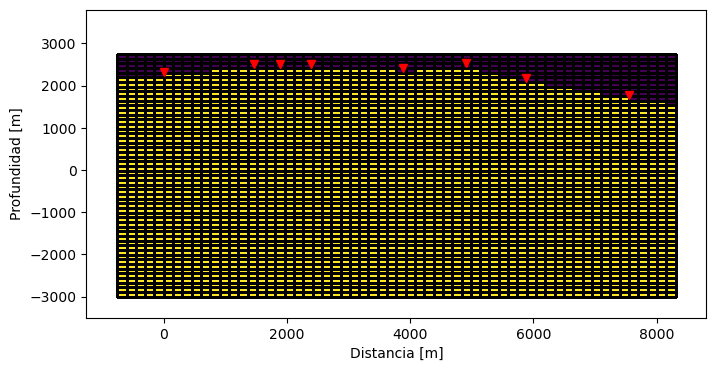

In [18]:
background_value=10.0

xx = np.array(np.meshgrid(mesh3.nodes_x))
zz = get_altura(create_perfil(stations[1:3]), xx)
topo = np.c_[mkvc(xx), mkvc(zz)]

air_value = 0.0
#ind_active = surface2ind_topo(mesh3, topo, "N")
ind_active = active_from_xyz(mesh3, topo, "N")
model_map = maps.InjectActiveCells(mesh3, ind_active, air_value)

model = background_value * np.ones(ind_active.sum())

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
mesh3.plot_image(model_map * model, ax=ax, grid=True)
ax.plot(rx_locs[:, 0], rx_locs[:, 1], "rv")
ax.set_xlim(-500, 9500)
ax.set_ylim(-2200, 4000)
ax.set_xlabel("Distancia [m]")
ax.set_ylabel("Profundidad [m]")
ax.set_xlim(-0.1*long_X-500, 1.1*long_X+500)
ax.set_ylim(-3500, 3800)
plt.show()


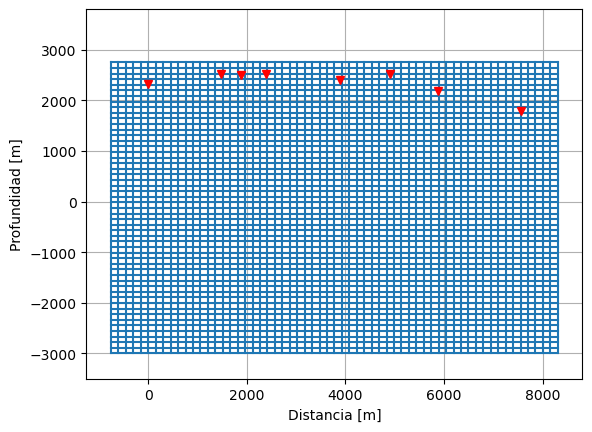

In [19]:
ax = mesh3.plot_grid()
ax.set_xlim(-0.1*long_X-500, 1.1*long_X+500)
ax.set_ylim(-3500, 3800)
ax.set_xlabel("Distancia [m]")
ax.set_ylabel("Profundidad [m]")

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "rv")

Se realizará las simulaciones de la resistividad aparente y la fase en los modos TE y Tm

In [20]:
# simulation class for TM mode
rx_list_tm = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="phase"
    ),
]
src_list_tm = [nsem.sources.Planewave(rx_list_tm, frequency=f) for f in frequencies]
survey_tm = nsem.Survey(src_list_tm)

act_map = maps.InjectActiveCells(mesh3, ind_active, np.log(1e-8))
exp_map = maps.ExpMap(mesh=mesh3)
sigma_map = exp_map * act_map

sim_tm= nsem.simulation.Simulation2DElectricField(
    mesh3,
    survey=survey_tm,
    sigmaMap=sigma_map,
    solver=Solver,
)

# simulation class for TE mode
rx_list_te = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase"
    ),
]
src_list_te = [nsem.sources.Planewave(rx_list_te, frequency=f) for f in frequencies]
survey_te = nsem.Survey(src_list_te)

sim_te = nsem.simulation.Simulation2DMagneticField(
    mesh3,
    survey=survey_te,
    sigmaMap=sigma_map,
    solver=Solver,
)

Genera un vector con los datos observador de los modos te y tm

In [21]:
dobs_te = np.hstack((app_rho_te, phase_te)).flatten()
dobs_tm = np.hstack((app_rho_tm, phase_tm)).flatten()

std_te = np.hstack((app_rho_err_te, phase_err_te)).flatten()
std_tm = np.hstack((app_rho_err_tm, phase_err_tm)).flatten()


Genera el modelo inicial

In [22]:
m0 = np.ones(ind_active.sum()) * np.log(1./rho_0)

In [23]:
rho_conductivo = 10

In [24]:
# Filtrar las celdas activas de la malla
gridCC_active = mesh3.gridCC[ind_active]
print(gridCC_active)

[[ -679.59791368 -2944.74      ]
 [ -528.57615508 -2944.74      ]
 [ -377.55439649 -2944.74      ]
 ...
 [ 4757.18539574  2360.22      ]
 [ 4908.20715434  2360.22      ]
 [ 5059.22891293  2360.22      ]]


In [25]:
# Definir una zona conductiva solo en los puntos activos
conductive_zone = (gridCC_active[:, 0] > 20) & (gridCC_active[:, 0] < 75) & (gridCC_active[:, 1] < -10)
print(np.unique(conductive_zone))

[False]


In [26]:
# Ahora aplicas el cambio en m0 con el índice filtrado
m0[conductive_zone] = np.log(1./rho_conductivo)


In [27]:
print(np.unique(m0))
len(m0)

[-3.91202301]


2827

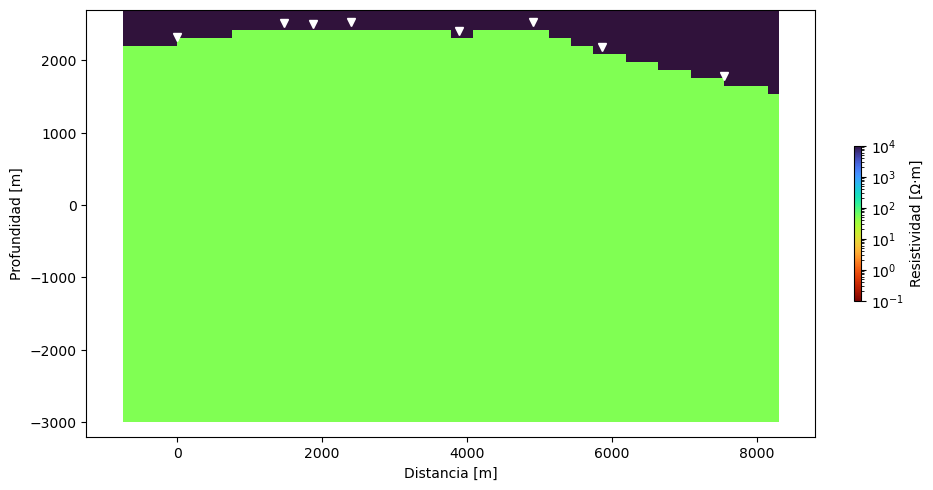

In [28]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,1, figsize=(10, 6))
m = m0
sigma = np.ones(mesh3.nC) * 1e-8
sigma[ind_active] = np.exp(m)
rho = 1 / sigma
sigma_min = 1e-4
sigma_max = 10
rho_min = 1/sigma_max
rho_max = 1/sigma_min
grid= False
out = mesh3.plot_image(
    rho, grid=grid, ax=ax, pcolor_opts={'norm':LogNorm(vmin=rho_min, vmax=rho_max), 'cmap':'turbo_r'},
    range_x=(-0.1*long_X-500, 1.1*long_X+500), range_y=(-3200, 2700)
)
cb = plt.colorbar(out[0], fraction=0.01, ax=ax)
cb.set_label("Resistividad [Ω·m]")
ax.set_aspect(1)
ax.set_xlabel("Distancia [m]")
ax.set_ylabel("Profundidad [m]")
ax.plot(rx_locs[:,0], rx_locs[:,1], 'wv')

## Inversion
El código corresponde a la inversión 2D con los datos procesados y la malla discretizada

### Inversion 2D

In [29]:
te_data_object = data.Data(survey_te, dobs=dobs_te, standard_deviation=std_te) 
tm_data_object = data.Data(survey_tm, dobs=dobs_tm, standard_deviation=std_tm) 
dmis_te = data_misfit.L2DataMisfit(data=te_data_object, simulation=sim_te)
dmis_tm = data_misfit.L2DataMisfit(data=tm_data_object, simulation=sim_tm)
dmis = dmis_te + dmis_tm


# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh3,
    indActive=ind_active,
    # ERROR -> 
    reference_model=m0,
    # Antes -> mref=m0
    # Corregir -> reference_model=m0
    alpha_s=alpha_s,
    alpha_x=alpha_y,
    alpha_y=alpha_z,
    mapping=maps.IdentityMap(nP=int(ind_active.sum()))
)

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=30)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define MT Inversion Directives
# ------------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=0.1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

save_dictionary = directives.SaveOutputDictEveryIteration()
save_dictionary.outDict = {}

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)


# ----> SI use_irls SE TOMARÁ EN CUENTA LOS HIPERPARAMETROS p_s, p_y, p_z DE LA NORMA LP

if use_irls:
    # ERROR --->
    reg.norms = np.r_[p_s, p_y, p_z]
    # Antes -> np.c_
    # Corregir -> np.r_

    # Reach target misfit for L2 solution, then use IRLS until model stops changing.
    IRLS = directives.Update_IRLS(max_irls_iterations=40, minGNiter=1, f_min_change=1e-5)

    # The directives are defined as a list.
    directives_list = [
        IRLS,
        starting_beta,
        save_dictionary,
    ]
else:
    directives_list = [
        starting_beta,
        beta_schedule,
        save_dictionary,
        target_misfit,
    ]

    
#####################################################################
# Running the MT Inversion
# ------------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
mt_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

La siguiente celda de código, corre la inversión, dependiendo del equipo tomará su tiempo en finalizar

In [ ]:

%%time

recovered_conductivity_model = mt_inversion.run(m0)



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DMagneticField problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.46e+04  3.03e+06  0.00e+00  3.03e+06    2.77e+06      0              
   1  1.23e+04  5.10e+05  1.59e+00  5.29e+05    3.66e+05      0              
   2  6.15e+03  1.94e+05  4.69e+00  2.22e+05    5.05e+04      0   Skip BFGS  
   3  3.08e+03  1.38e+05  8.63e+00  1.65e+05    9.52e+03      0   Skip BFGS  
   4  1.54e+03  1.18e+05  1.33e+01  1.39e+05    4.83e+03      0   Skip BFGS  
   5  7.69e+02  1.03e+05  2.05e+01  1.19e+05    3.96e+03      0   Skip BFGS  
   6  3.84e+02  8.78e+04  3

In [376]:
"""
import pickle
out_dict = save_dictionary.outDict 
with open("inversion2D_p03.pkl", "wb") as file:
    pickle.dump(out_dict, file)
"""

'\nimport pickle\nout_dict = save_dictionary.outDict \nwith open("inversion2D_p03.pkl", "wb") as file:\n    pickle.dump(out_dict, file)\n'

In [381]:

import pickle
# Para cargar el diccionario desde el archivo
with open('Inversion2D_perfil3.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

print(loaded_dict)

{1: {'iter': 1, 'beta': 793.6332961153704, 'phi_d': 528174.0581328539, 'phi_m': 9.780752849431638, 'f': 687964.1643736246, 'm': array([-3.02405444, -3.37403953, -3.54920101, ..., -4.13596837,
       -4.29055136, -4.64321251]), 'dpred': array([  96.97738162,   80.43968591,   45.53157661, ..., -166.64085427,
       -166.27765292, -164.29031669]), 'SparseSmallness.irls_threshold': 1e-08, 'SparseSmallness.norm': 2.0, 'x SparseSmoothness.irls_threshold': 1e-08, 'x SparseSmoothness.norm': 2.0, 'y SparseSmoothness.irls_threshold': 1e-08, 'y SparseSmoothness.norm': 2.0}, 2: {'iter': 2, 'beta': 396.8166480576852, 'phi_d': 485271.858104268, 'phi_m': 27.582966020806474, 'f': 535936.3892552382, 'm': array([-1.51974581, -2.51819096, -3.05927405, ..., -4.32883392,
       -4.55997453, -5.03166107]), 'dpred': array([  85.16544165,   68.72806774,   51.52493161, ..., -158.33169957,
       -157.42108497, -151.71454013]), 'SparseSmallness.irls_threshold': 1e-08, 'SparseSmallness.norm': 2.0, 'x SparseSmoot

In [382]:
#output_dict = save_dictionary.outDict
output_dict = loaded_dict
target_misfit = (dobs_te.size+dobs_tm.size) / 2.
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']

In [383]:

import matplotlib
matplotlib.rcParams['font.size'] = 14
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    #plt.savefig("curva2d.png", dpi=300, bbox_inches='tight')  # Guardar con alta calidad
    plt.show()

In [384]:

from ipywidgets import interact, widgets
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=27, description='iteration', max=27, min=1), RadioButtons(description='s…

In [385]:

from matplotlib.colors import LogNorm
iteration = Q_iter.widget.kwargs['iteration']
m = output_dict[iteration]['m']

In [386]:
def foo_model(iteration):
    fig, ax = plt.subplots(1,1, figsize=(10, 6))
    m = output_dict[iteration]['m']
    sigma = np.ones(mesh3.nC) * 1e-8
    sigma[ind_active] = np.exp(m)
    rho = 1 / sigma
    sigma_min = 1e-4
    sigma_max = 10
    rho_min = 1/sigma_max
    rho_max = 1/sigma_min
    grid= False
    out = mesh3.plot_image(
        rho, grid=grid, ax=ax, pcolor_opts={'norm':LogNorm(vmin=rho_min, vmax=rho_max), 'cmap':'Spectral'},
        range_x=(-500, rx_locs.max()+500), range_y=(-3000, 2500)
    )
    cb = plt.colorbar(out[0], fraction=0.0256, ax=ax)
    cb.set_label("Resistivity [Ω·m]")
    ax.set_aspect(1)
    ax.set_xlabel("Distance [m]")
    ax.set_title("Inverted 2D resistivity model of profile 1")
    ax.set_ylabel("Depth [m]")
    ax.plot(rx_locs[:,0], rx_locs[:,1], 'wv')

    #Perfi01
    ax.text(-300, 2650, "NW", fontsize=14, ha='center', va='center')
    ax.text(9300, 2650, "SE", fontsize=14, ha='center', va='center')


    #plt.savefig("Inv2D_P01.png", dpi=300, bbox_inches='tight')  # Guardar con alta calidad
    
    #out = mesh_true.plot_image(
    #    sigma_true, grid=grid, ax=ax1, pcolor_opts={'norm':LogNorm(vmin=sigma_min, vmax=sigma_max), 'cmap':'turbo'},
    #    range_x=(-60000, 60000), range_y=(-30000, 0)
    #)
    #cb = plt.colorbar(out[0], fraction=0.01, ax=ax1)
    #cb.set_label("Conductivity (S/m)")
    #ax1.set_aspect(1)
    #ax1.set_xlabel("Easting (m)")
    #ax1.set_ylabel("Elevation (m)")

In [387]:

Q_misfit = interact(
    foo_model, 
    iteration=widgets.IntSlider(min=1, max=n_iteration, value=iteration),
) 

interactive(children=(IntSlider(value=27, description='iteration', max=27, min=1), Output()), _dom_classes=('w…

# Respuesta

In [339]:
iteration = 1
m = output_dict[iteration]['m']
m

array([ 0.74567567, -1.41605674, -2.49564177, ..., -3.83972982,
       -2.63281097, -1.45995968])

In [340]:
sigma[ind_active] = np.exp(m)

In [341]:
sigma[ind_active].shape

(2834,)

In [342]:
np.exp(m).shape

(2834,)

In [45]:
pred_te = sim_te.dpred(m)
pred_tm = sim_tm.dpred(m)

In [50]:

n_freq = len(frequencies)
n_rx = rx_locs.shape[0]

In [51]:

PRED_te = pred_te.reshape((n_freq, 2, n_rx))
PRED_tm = pred_tm.reshape((n_freq, 2, n_rx))

rho_app_te_pred = PRED_te[:,0,:]
rho_app_tm_pred = PRED_tm[:,0,:]

phase_te_pred = PRED_te[:,1,:]
phase_tm_pred = PRED_tm[:,1,:]

DOBS_te = dobs_te.reshape((n_freq, 2, n_rx))
DOBS_tm = dobs_tm.reshape((n_freq, 2, n_rx))

rho_app_te_dobs = DOBS_te[:,0,:]
rho_app_tm_dobs = DOBS_tm[:,0,:]

phase_te_dobs = DOBS_te[:,1,:]
phase_tm_dobs = DOBS_tm[:,1,:]

In [52]:
PRED_te

array([[[ 49.12880068,  49.12091674,  48.87053441,  35.6369492 ,
          37.80789191,  71.63815597, 144.10341807],
        [ 77.14376236,  69.79845161,  60.89873825,  77.50522238,
          81.51144527,  62.30161417,  48.12431004]],

       [[ 43.18010716,  44.99691498,  46.81086474,  31.31944545,
          32.47681302,  69.39400153, 144.16319381],
        [ 75.08150248,  67.04530653,  60.18336858,  75.65993325,
          80.03411377,  60.54926546,  48.86261298]],

       [[ 38.43201263,  41.97115718,  44.9823881 ,  27.76808937,
          28.01781494,  67.8110225 , 143.01888349],
        [ 72.80750957,  64.29881324,  59.62006838,  73.67171047,
          78.3128463 ,  59.16597559,  49.659126  ]],

       [[ 34.73088431,  39.83635542,  43.29324102,  24.85226964,
          24.31655795,  66.57678429, 140.78245704],
        [ 70.38869725,  61.66962817,  59.24200661,  71.56807793,
          76.32171507,  58.17111815,  50.45493842]],

       [[ 31.9260854 ,  38.39731579,  41.62699785,  22.4

In [53]:

def foo_pred(irx):
    import matplotlib
    matplotlib.rcParams['font.size'] = 10


    error_rho_te = np.mean(np.abs(rho_app_te_pred[:, irx] - rho_app_te_dobs[:, irx]) / rho_app_te_dobs[:, irx]) * 100
    error_rho_tm = np.mean(np.abs(rho_app_tm_pred[:, irx] - rho_app_tm_dobs[:, irx]) / rho_app_tm_dobs[:, irx]) * 100
    error_phase_te = np.mean(np.abs(phase_te_pred[:, irx] - phase_te_dobs[:, irx]) / phase_te_dobs[:, irx]) * 100
    error_phase_tm = np.mean(np.abs(phase_tm_pred[:, irx] - phase_tm_dobs[:, irx]) / phase_tm_dobs[:, irx]) * 100

    fig, axs = plt.subplots(4,1, figsize=(8, 10))
    ax1, ax2, ax3, ax4 = axs
    ax1.loglog(1./frequencies, rho_app_te_pred[:, irx], color='C0', label="dpred")
    ax1.loglog(1./frequencies, rho_app_te_dobs[:, irx], 'x', color='C0', label="dobs")
    ax1.legend()
    ax1.text(0.05, 0.95, f"Error: {error_rho_te:.2f}%", transform=ax1.transAxes, verticalalignment='top')


    ax2.loglog(1./frequencies, rho_app_tm_pred[:, irx], color='C1', label="dpred")
    ax2.loglog(1./frequencies, rho_app_tm_dobs[:, irx], 'x', color='C1', label="dobs")
    ax2.legend()
    ax2.text(0.05, 0.95, f"Error: {error_rho_tm:.2f}%", transform=ax2.transAxes, verticalalignment='top')


    for ax in axs[:2]:
        ax.set_ylim(1, 100000)
        ax.set_ylabel("App. Res. (Ohm-m)")
        ax.grid(which='both', alpha=0.3)
    ax3.semilogx(1./frequencies, phase_te_pred[:, irx], color='C0', label="dpred")
    ax3.semilogx(1./frequencies, phase_te_dobs[:, irx], 'x', color='C0', label="dobs")
    ax3.legend()
    ax3.text(0.05, 0.95, f"Error: {error_phase_te:.2f}%", transform=ax3.transAxes, verticalalignment='top')


    ax4.semilogx(1./frequencies, phase_tm_pred[:, irx]+180, color='C1', label="dpred")
    ax4.semilogx(1./frequencies, phase_tm_dobs[:, irx]+180, 'x', color='C1', label="dobs")
    ax4.legend()
    ax4.text(0.05, 0.95, f"Error: {error_phase_tm:.2f}%", transform=ax4.transAxes, verticalalignment='top')


    for ax in axs[2:]:
        ax.set_ylim(0, 90)
        ax.set_ylabel("Phase (degree)")
        ax.grid(which='both', alpha=0.3)
    ax4.set_xlabel("Period (s)")
    ax1.set_title(f"irx = {irx}")

    #plt.savefig("respuesta_2d.png", dpi=300, bbox_inches='tight')  # Guardar con alta calidad

In [ ]:

Q_misfit = interact(
    foo_pred, 
    irx=widgets.IntSlider(min=0, max=int(n_rx)-1, value=0),
)

interactive(children=(IntSlider(value=0, description='irx', max=6), Output()), _dom_classes=('widget-interact'…

In [ ]:
import pickle
# Guardar el diccionario en un archivo
with open('output_dict.pkl', 'wb') as f:
    pickle.dump(output_dict, f)

{1: {'iter': 1, 'beta': 8033985.757660331, 'phi_d': 2457150533.1096783, 'phi_m': 6.16553904766889, 'f': 17025914781.678867, 'm': array([-6.90631974, -6.90630203, -6.90481133, ..., -7.22885391,
       -7.16557928, -6.88122954]), 'dpred': array([ 1.00501489e+03,  1.11687364e+03,  1.02640068e+03,  1.19550211e+03,
        9.35016259e+02,  8.56942554e+02,  8.90835383e+02,  1.03273552e+03,
        4.52305642e+01,  5.00498074e+01,  4.66236366e+01,  4.91694442e+01,
        4.88120999e+01,  4.79897690e+01,  4.58871323e+01,  4.88901561e+01,
        9.99691076e+02,  1.07869825e+03,  1.01143230e+03,  1.14827965e+03,
        9.27592465e+02,  8.52296955e+02,  8.76199402e+02,  1.00768971e+03,
        4.51971979e+01,  4.90066415e+01,  4.63891861e+01,  4.87432886e+01,
        4.73632846e+01,  4.65416403e+01,  4.54937349e+01,  4.80282076e+01,
        9.97202424e+02,  1.04991391e+03,  9.95690232e+02,  1.10502911e+03,
        9.22710399e+02,  8.54001992e+02,  8.69610719e+02,  9.89780299e+02,
        4.466

In [129]:
import pickle
# Para cargar el diccionario desde el archivo
with open('inversion2D_1.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

print(loaded_dict)

{1: {'iter': 1, 'beta': 8033985.757660331, 'phi_d': 2457150533.1096783, 'phi_m': 6.16553904766889, 'f': 17025914781.678867, 'm': array([-6.90631974, -6.90630203, -6.90481133, ..., -7.22885391,
       -7.16557928, -6.88122954]), 'dpred': array([ 1.00501489e+03,  1.11687364e+03,  1.02640068e+03,  1.19550211e+03,
        9.35016259e+02,  8.56942554e+02,  8.90835383e+02,  1.03273552e+03,
        4.52305642e+01,  5.00498074e+01,  4.66236366e+01,  4.91694442e+01,
        4.88120999e+01,  4.79897690e+01,  4.58871323e+01,  4.88901561e+01,
        9.99691076e+02,  1.07869825e+03,  1.01143230e+03,  1.14827965e+03,
        9.27592465e+02,  8.52296955e+02,  8.76199402e+02,  1.00768971e+03,
        4.51971979e+01,  4.90066415e+01,  4.63891861e+01,  4.87432886e+01,
        4.73632846e+01,  4.65416403e+01,  4.54937349e+01,  4.80282076e+01,
        9.97202424e+02,  1.04991391e+03,  9.95690232e+02,  1.10502911e+03,
        9.22710399e+02,  8.54001992e+02,  8.69610719e+02,  9.89780299e+02,
        4.466